# Fine-tuned Vision Transformer (ViT)

Pre-trained Vision Transformer (ViT) model for image classification for waste classification.

The specific ViT is `ViT-B_32`, which has been pretrained on both the imagenet21k and imagenet2012 image databases. In this notebook the ViT model is fine-tuned on the `Wastenet` dataset featuring ~2500 images over 6 classes of objects, all of which are single instances.

## Runtime Type
This notebook is intended to be executed in a GPU or TPU environment with high RAM availability. 

# Libraries and Configurations

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
!pip install tensorflow-addons
import tensorflow_addons as tfa
import glob, random, os, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

import zipfile
import os

import cv2

print('TensorFlow Version ' + tf.__version__)

def seed_everything(seed = 0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything()
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 14.5 MB/s 
TensorFlow Version 2.8.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Dataset & Labels
The Wastenet dataset is comprised of 2 files; a zip archive containing the images and a text file containing the labels:
*   `dataset-resized.zip` is extracted into a temporary directory within the development environment
*   `zero-indexed-files.txt` is read into a DataFrame object. As the name indicates, the 6 unique class label values range from zero through five. 

This notebook expects both files to be available in a Google drive, with the path /My Drive/Data/.

### Extending the Training Data
This notebook has been developed to be congruent with the file layout of the Trashnet dataset, meaning that all content can be found in a folder named `dataset-resized` with subfolders for each object class (cardboard, glass, metal, paper, plastic, trash). Within each subfolder are JPEG images with the following filenames: `<object class>[0-9]+.jpg`, where the numeric suffix is unique.

Additional data should follow this format, or this notebook will need to be altered to accommodate some other convention.

In [3]:
zip_ref = zipfile.ZipFile('/content/drive/My Drive/ViT/Dataset/Trashnet/dataset-resized.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

label_df = pd.read_csv('/content/drive/My Drive/ViT/Dataset/Trashnet/zero-indexed-files.txt', sep='\s', names=['Filename', 'Label'])

In [4]:
label_df.sort_values('Filename', inplace=True)

## Reading Path and Filenames for the Image Dataset
The filenames of the extracted images are all read into a list and include path information relative to the `dataset-resized` subfolder. E.g. 'cardboard/cardboard40.jpg'

In [5]:
trash_types = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
dataset_files = []
file_count = 0

for type in trash_types:
  temp = []
  path = os.path.join("/tmp/dataset-resized/", type)
  folder_name = type+"/"
  dataset_files.append(list(map(folder_name.__add__,os.listdir(path))))

  for root_dir, cur_dir, files in os.walk(path):
    file_count += len(files)

In [6]:
# Flatten the dataset_files list into a single generation (layer)
def flatten(input):
    new_list = []
    for i in input:
        for j in i:
            new_list.append(j)
    return new_list

## Producing Data (X) and Labels (y)

In [7]:
X = sorted(flatten(dataset_files))
y = label_df['Label'].values

### Train / Test Split
There is no need for a validation split, as that can be taken care of using the ImageDataGenerator class later on.

Initial training data size: 85% <br>
Initial testing data size: 15%

Note that DataFrames are used for ease of use with the ImageDataGenerator class (explained later).

In [8]:
# Just train/test. Val will come from ImageDataGenerator
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Convert to DataFrames for ease of use
DF_TRAIN = pd.DataFrame(X_train, columns = ['image_path'])
DF_TRAIN['label'] = y_train
DF_TEST  = pd.DataFrame(X_test, columns = ['image_path'])
DF_TEST['label'] = y_test

DF_TEST.head()

,image_path,label
0,paper/paper494.jpg,1
1,glass/glass41.jpg,0
2,cardboard/cardboard274.jpg,2
3,metal/metal275.jpg,4
4,metal/metal346.jpg,4


## Constants & Configurable Parameters
`IMAGE_SIZE` needs to remain at 384 pixels, because the ViT was pretrained on data of that dimension (384 x 384 images). <br>
`BATCH_SIZE` of 16 is the default value. <br>
`EPOCHS` the number of epochs that the model will train, default is 7. <br>
`n_classes` and `classes` reflect the Trashnet dataset characteristics.

In [9]:
IMAGE_SIZE = 384 # Keep this value fixed!
BATCH_SIZE = 16
EPOCHS = 7

classes = {0 : "Glass",
           1 : "Paper",
           2 : "Cardboard",
           3 : "Plastic",
           4 : "Metal",
           5 : "Trash"}

n_classes = len(classes)

## Formatting Label Data
Use of an integer label, in the range of `[0, 5]` is not compatible with the ViT model. Instead either of the following options are used: 
1.   a 6 element list is used, in which all positions are zero except for the position representing class membership
2.   a categorical string (i.e. a word)

For example, consider the following table, which first has an ordinal integer (`label`), a list or bitmask style representation (`label_cat`) and lastly a human readable class string (`label_str`)

| label | label_cat | label_str |
|:-----:|-----------|:---------:|
| 3     | [0,0,0,1,0,0] | Plastic |
| 2     | [0,0,1,0,0,0] | Cardboard |
| 4     | [0,0,0,0,1,0] | Metal |
| 5     | [0,0,0,0,0,1] | Trash |
| 1     | [0,1,0,0,0,0] | Paper |
| 0     | [1,0,0,0,0,0] | Glass |

The data generator can make use of either the list or string depending on the generator's configuration.

In [10]:
def label_2_list (x):
  list_format = [0] * n_classes
  list_format[x] = 1
  return list_format

def label_2_str (x):
  return classes[x]

In [11]:
DF_TEST['label_cat'] = DF_TEST['label'].apply(label_2_list)
DF_TEST['label_str'] = DF_TEST['label'].apply(label_2_str)

DF_TRAIN['label_cat'] = DF_TRAIN['label'].apply(label_2_list)
DF_TRAIN['label_str'] = DF_TRAIN['label'].apply(label_2_str)

# Data Augmentations
Data augmentations are import with the ViT model as it can *learn* from variations and permutations of an original image.

The following function performs random rotations and flips of the image. **NOTE:** One area that should be explored is adding in various forms of image distortion. When considering images of waste, it is rarely guaranteed that the object remains in pristine form. Having an appropriate data augmentation routine could help generate significant synthetic data, expanding the effective dataset.



In [12]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
 
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    return image

# Data Generator
The ImageDataGenerator class is highly useful, as it performs a large number of operations on the data. In this particular instance it:

*   **rescale:** scales all inputs to be between `[0,1]`
*   **samplewise_center:** sets each sample mean to zero
*   **samplewise_std_normalization:** divides inputs by std of the dataset
*   **validation_split:** reserves 17% of training data to be used as validation data
*   **preprocessing_function:** performs data augmentation on inputs



In [13]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          samplewise_center = True,
                                                          samplewise_std_normalization = True,
                                                          validation_split = 0.17,#) # 0.17 split is close to 15% of original dataset
                                                          preprocessing_function = data_augment)

## Training, Validation and Testing Data Generators
Notable Arguments for the different generators are as follows:
*   `dataframe` is the information source for `x_col` (image path) and `y_col` (image class)
*   `subset` is either 'training', 'validation', or omitted. If 'training' or 'validation' then the `validation_split` proportion applies
*   `batch_size` can be different values, but needs to correspond with the model hyperparameter for training and validation generators. It can be independent for the test generator
*   `class_mode` can be either 'input' or 'categorical', but the label information (`y_col`) must be either list format or string format respectively

Each data generator will output how many image filenames were found and how many object classes are represented.



In [14]:
train_gen = datagen.flow_from_dataframe(dataframe = DF_TRAIN,
                                        directory = "/tmp/dataset-resized/",
                                        x_col = 'image_path',
                                        y_col = 'label_str',  #'label_cat',
                                        subset = 'training',
                                        batch_size = BATCH_SIZE,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = True,
                                        #class_mode = 'input',
                                        class_mode = 'categorical',
                                        target_size = (IMAGE_SIZE, IMAGE_SIZE))

valid_gen = datagen.flow_from_dataframe(dataframe = DF_TRAIN,
                                        directory = "/tmp/dataset-resized/",
                                        x_col = 'image_path',
                                        y_col = 'label_str',  #'label_cat',
                                        subset = 'validation',
                                        batch_size = BATCH_SIZE,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = False,
                                        #class_mode = 'input',
                                        class_mode = 'categorical',
                                        target_size = (IMAGE_SIZE, IMAGE_SIZE))

test_gen = datagen.flow_from_dataframe(dataframe = DF_TEST,
                                        directory = "/tmp/dataset-resized/",
                                        x_col = 'image_path',
                                        y_col = 'label_str',  #'label_cat',
                                        batch_size = 1, # was BATCH_SIZE
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = False,
                                        #class_mode = 'input',
                                        class_mode = 'categorical',
                                        target_size = (IMAGE_SIZE, IMAGE_SIZE))

Found 1783 validated image filenames belonging to 6 classes.
Found 364 validated image filenames belonging to 6 classes.
Found 380 validated image filenames belonging to 6 classes.


## Resizing Trashnet Images
The original dimensions of Trashnet images are 384 x 512 pixels with 3 RGB channels.

The ViT model was pre-trained on images which were 384 x 384 pixels with 3 RGB channels, so the Trashnet images need to be resized. In this case the images won't be scaled to preserve ratios, but instead distorted (i.e. squeezed) into the expected dimensions.

The example image, a plastic capsule, is read from the training data and both its original and resized perspectives are shown.

In [15]:
img = cv2.imread("/tmp/dataset-resized/"+DF_TRAIN['image_path'][0])

# Get original height and width
print(f"Original Dimensions : {img.shape}")

# resize image by specifying custom width and height
resized = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))

print(f"Resized Dimensions : {resized.shape}")
cv2.imwrite('resized_imaged.jpg', resized)

Original Dimensions : (384, 512, 3)
Resized Dimensions : (384, 384, 3)


True

plastic/plastic148.jpg


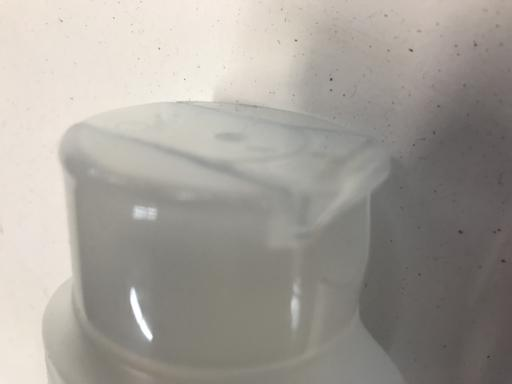

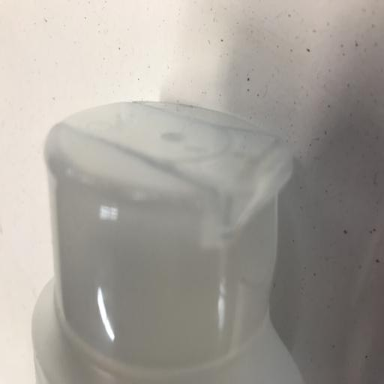

In [16]:
# patch necessary to address Colab-specific issue with cv2.imshow()
from google.colab.patches import cv2_imshow

imgpath = DF_TRAIN['image_path'][0]
print(imgpath)

img = cv2.imread("/tmp/dataset-resized/"+imgpath)

cv2_imshow(img)
img = cv2.cvtColor(img, cv2.COLOR_YCrCb2RGB);
cv2_imshow(resized)

## Visualizing more Training Data
Sixteen images from the training data generator are presented. Note the flipping and rotation in them (e.g. backward text) from the data augmentation function.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


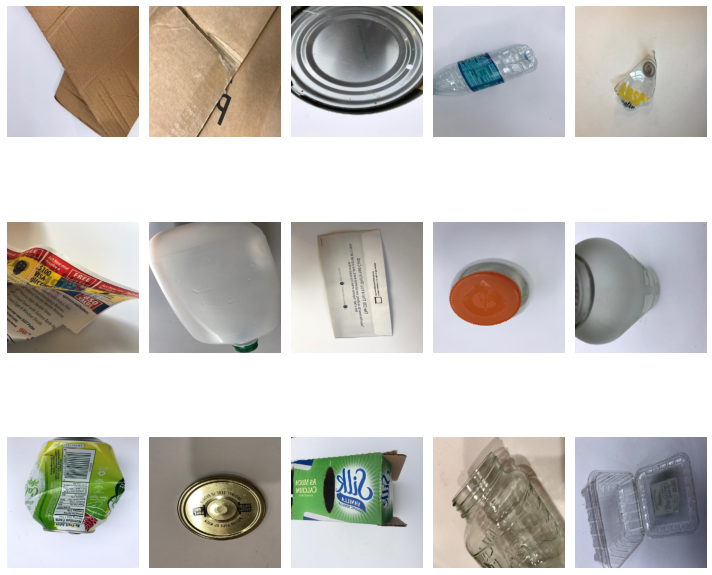

In [17]:
images = [train_gen[0][0][i] for i in range(BATCH_SIZE)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))
axes = axes.flatten()


for img, ax in zip(images, axes):
    
    # Important! Normalize values, 0-255 or 0-1 expected
    norm_img = cv2.normalize(img,img,0,1,cv2.NORM_MINMAX)

    ax.imshow(norm_img.reshape(IMAGE_SIZE, IMAGE_SIZE, 3))
    ax.axis('off')

plt.tight_layout()
plt.show()

# Build the Vision Transformer Model


1.   Install the necessary packages
2.   Create an instance of the pre-trained model
3.   Create a new model top
4.   Fine-tune the model



In [18]:
!pip install --quiet vit-keras

from vit_keras import vit

## Instantiating the Pre-trained ViT-B_32 Model
The ViT model allows for a customized *top* (or head), replacing the original.

In [19]:
vit_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = n_classes)

353263616/353253686 [==============================] - 11s 0us/step


## New ViT Model Top
The model top is simple, with only 5 layers including the output. If a larger number of object classes is desired, the first parameter of the first `Dense` layer ought to be increased proportionately.

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87528192  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 11)                8459      
                                                                 
 batch_normalization_1 (Batc  (None, 11)               44        
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 6)          

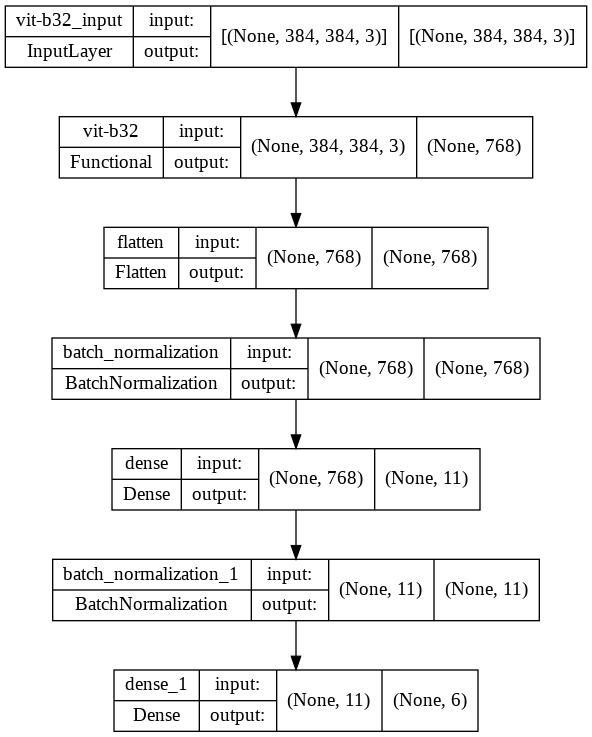

In [20]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(n_classes, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

## Fine-tuning the Model
Many ViT model hyperparameters are located in the following cell:
*   Learning rate, 1e-4
*   Optimizer, RectifiedAdam
*   Callback functions, **ReduceLROnPlateau**, **EarlyStopping**, **ModelCheckpoint** -- all callbacks are configured to monitor validation accuracy
*   Loss Function, Categorical Crossentropy
*   Metric, Accuracy

It is worthwhile to note that the hyperparameters have not been optimized. The Trashnet dataset did not represent the eventual complexity of a realistic dataset, but when it is extended or replaced by a more comprehensive dataset (or datasets) the model should be optimized. 




In [21]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer]

model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = callbacks)

Epoch 1/7
111/111 [==============================] - ETA: 0s - loss: 1.8273 - accuracy: 0.3611
Epoch 1: val_accuracy improved from -inf to 0.64773, saving model to ./model.hdf5
111/111 [==============================] - 94s 501ms/step - loss: 1.8273 - accuracy: 0.3611 - val_loss: 1.3480 - val_accuracy: 0.6477 - lr: 1.0000e-04
Epoch 2/7
111/111 [==============================] - ETA: 0s - loss: 1.2867 - accuracy: 0.6899
Epoch 2: val_accuracy improved from 0.64773 to 0.83523, saving model to ./model.hdf5
111/111 [==============================] - 52s 471ms/step - loss: 1.2867 - accuracy: 0.6899 - val_loss: 1.1284 - val_accuracy: 0.8352 - lr: 1.0000e-04
Epoch 3/7
111/111 [==============================] - ETA: 0s - loss: 1.1072 - accuracy: 0.8240
Epoch 3: val_accuracy improved from 0.83523 to 0.88920, saving model to ./model.hdf5
111/111 [==============================] - 52s 473ms/step - loss: 1.1072 - accuracy: 0.8240 - val_loss: 1.0114 - val_accuracy: 0.8892 - lr: 1.0000e-04
Epoch 4/7


## Saving the Trained Model
The ViT model is saved in 2 different formats: `SavedModel` and `H5`.<br>
The saved model contents are copied to a persistent storage location (Google drive again) for later access.

In [22]:
model.save('ViT-model.h5')

# Also save in alternate format, "SavedModel"
!mkdir -p saved_model
model.save('saved_model/ViT-model')

INFO:tensorflow:Assets written to: saved_model/ViT-model/assets


INFO:tensorflow:Assets written to: saved_model/ViT-model/assets


In [23]:
# Copy over to Google Drive for more permanence
!cp ViT-model.h5 '/content/drive/MyDrive/ViT/'
!cp -R 'saved_model/ViT-model' '/content/drive/MyDrive/ViT/'

# Model Results on Validation Dataset
Although the model has already *seen* the validation data, the only metric reported for it was basic classification accuracy. The classification report and confusion matrix provides more information.

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        64
           1       0.93      0.93      0.93        72
           2       0.92      0.98      0.95        50
           3       0.94      0.98      0.96        85
           4       0.91      0.91      0.91        66
           5       1.00      0.78      0.88        27

    accuracy                           0.94       364
   macro avg       0.94      0.92      0.93       364
weighted avg       0.94      0.94      0.94       364



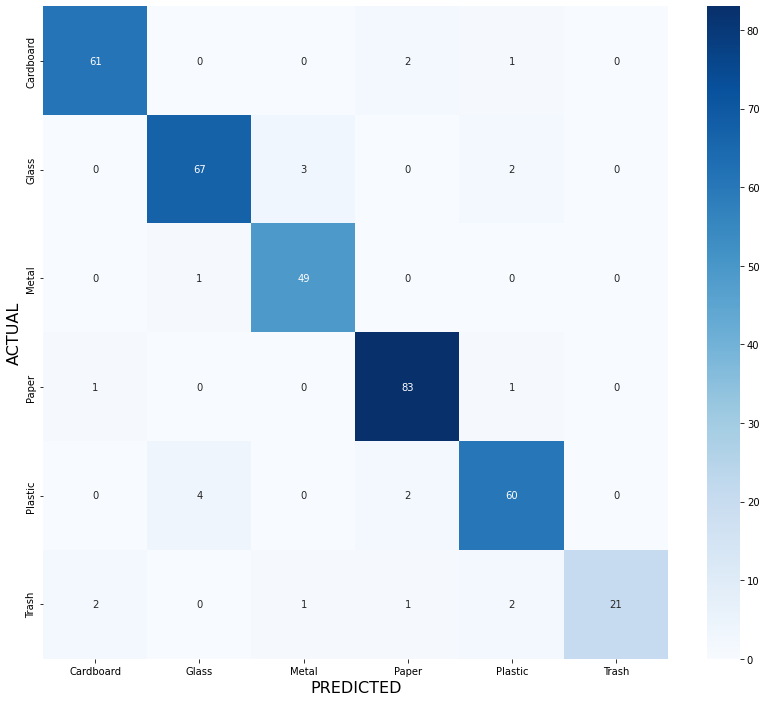

In [24]:
predicted_classes = np.argmax(model.predict(valid_gen, steps = valid_gen.n // valid_gen.batch_size + 1), axis = 1)
true_classes = valid_gen.classes
class_labels = list(valid_gen.class_indices.keys())  

confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (14, 12))
s = sns.heatmap(confusionmatrix, cmap='Blues', annot=True, cbar=True, xticklabels=class_labels, yticklabels=class_labels)
s.set_xlabel('PREDICTED', fontsize=16)
s.set_ylabel('ACTUAL', fontsize=16)

print(classification_report(true_classes, predicted_classes))

## Model Results on Test Dataset
Unlike the validation data, the ViT model has never seen the test data. If the number of training epochs (`EPOCHS`) was too high and overfitting to the training data occured, there will be a significant drop in accuracy in the test data classification. At '7' epochs, there is no overfitting issue for the Trashnet dataset.

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        52
           1       0.95      0.94      0.94        80
           2       0.92      0.94      0.93        71
           3       0.91      0.98      0.95        88
           4       0.92      0.92      0.92        74
           5       0.80      0.53      0.64        15

    accuracy                           0.93       380
   macro avg       0.92      0.88      0.89       380
weighted avg       0.93      0.93      0.93       380



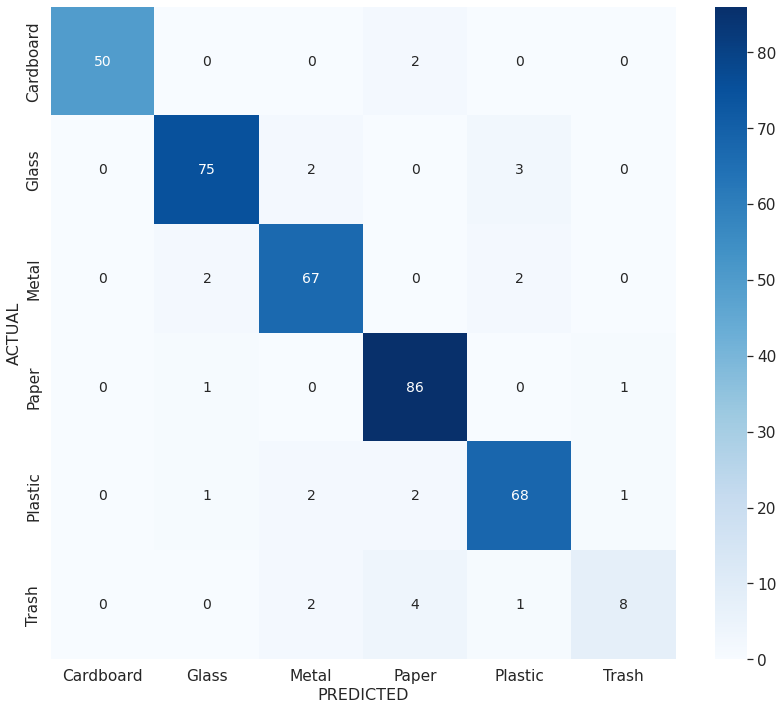

In [25]:
predicted_classes = np.argmax(model.predict(test_gen, steps = test_gen.n // test_gen.batch_size + 1), axis = 1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())  

confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (14, 12))
# increase font for all sns stuff
sns.set(font_scale=1.4)
s = sns.heatmap(confusionmatrix, cmap='Blues', annot=True, annot_kws={"size": 14}, cbar=True, xticklabels=class_labels, yticklabels=class_labels)
s.set_xlabel('PREDICTED', fontsize=16)
s.set_ylabel('ACTUAL', fontsize=16)

print(classification_report(true_classes, predicted_classes))

# Summary

The fine-tuned ViT model performs well classifying the Trashnet dataset. Ultimately this model should be targeted towards brand classification rather than waste classification. This is because the YOLOv5 model performs exceptional object detection and classification, while the ViT model performs only classification. Plus the ViT model does not require a dataset with object bounding boxes or masks.

**Suggested Improvements:**
* The new ViT model top could be improved, as it is a simplistic version.
* The ViT model hyperparameters could be optimized using a variety of packages, e.g. Optuna, Keras Tuner, etc.
* Additional datasets could be aggregated with Trashnet, introducing additional object classes, but as mentioned earlier the real potential of the ViT model is as the classification node downstream from the YOLOv5 model, focusing on brand classification.

**References & Credit:** <br>

* The following notebook served as a basis for this work, thanks to Rauf Momin:
https://www.kaggle.com/code/raufmomin/vision-transformer-vit-from-scratch
* The Trashnet Dataset was created by Gary Thung and Mindy Yang: https://github.com/garythung/trashnet
